In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Dict, Tuple, List, Optional

In [11]:
# To do:
# skewed distribution: done
# batch effects simulation: done
# fix acceptance_values based on process capability: not done
# simplify plotting function: not done
# freplace synthetic data with real dataset: not done

In [12]:
class CompositeAnalysis:
    def __init__(self, 
                 mean_strength: float = 1000,
                 std_dev: float = 50,
                 num_batches: int = 5,
                 samples_per_batch: int = 6):
        """
        Initialize with more realistic composite material variation factors
        
        Parameters:
        -----------
        mean_strength: float
            Base mean strength
        std_dev: float
            Base standard deviation
        num_batches: int
            Number of batches
        samples_per_batch: int
            Samples per batch
        """
        self.mean_strength = mean_strength
        self.std_dev = std_dev
        self.num_batches = num_batches
        self.samples_per_batch = samples_per_batch
        
        # Knockdown factors
        self.knockdown_factors = {
            'material_variability': 0.95,  # Material variability factor
            'safety_factor': 0.85,         # Safety factor
            'environmental': 0.90,         # Environmental effects
            'manufacturing': 0.92          # Manufacturing variability
        }
        
        # Batch effect parameters
        self.batch_effects = {
            'raw_material_variation': 0.03,    # Coefficient of variation for raw material
            'supplier_variation': 0.04,        # Additional variation from supplier changes
            'process_drift_rate': 0.01         # Rate of drift per batch
        }
        
        # Distribution shape parameters
        self.distribution_params = {
            'skewness': -0.5,              # Negative skew 
            'outlier_probability': 0.05,    # 5% chance of outliers
            'outlier_severity': 2.0         # putliers distance
        }
    
    def apply_knockdown_factors(self, strength_value: float) -> float:
        """Apply all knockdown factors to a strength value"""
        total_knockdown = np.prod(list(self.knockdown_factors.values()))
        return strength_value * total_knockdown
    
    def generate_batch_parameters(self) -> List[Dict]:
        """Generate batch parameters including supplier and process drift effects"""
        batch_params = []
        current_drift = 0
        
        for batch in range(self.num_batches):
            # Simulate supplier changes (random steps in material properties)
            supplier_effect = np.random.normal(1.0, self.batch_effects['supplier_variation'])
            
            # Simulate process drift over time
            current_drift -= self.batch_effects['process_drift_rate']
            
            # Simulate raw material variation
            raw_material_effect = np.random.normal(1.0, self.batch_effects['raw_material_variation'])
            
            batch_params.append({
                'batch_id': batch,
                'supplier_effect': supplier_effect,
                'process_drift': current_drift,
                'raw_material_effect': raw_material_effect
            })
        
        return batch_params
    
    def generate_skewed_distribution(self, size: int, mean: float, std: float) -> np.ndarray:
        """Generate skewed distribution using skew-normal distribution"""
        return stats.skewnorm.rvs(
            a=self.distribution_params['skewness'],
            loc=mean,
            scale=std,
            size=size
        )
    
    def add_outliers(self, data: np.ndarray) -> np.ndarray:
        """Add realistic outliers to the dataset"""
        n_outliers = int(len(data) * self.distribution_params['outlier_probability'])
        outlier_indices = np.random.choice(len(data), n_outliers, replace=False)
        
        for idx in outlier_indices:
            # Randomly decide if outlier is high or low
            direction = np.random.choice([-1, 1])
            severity = np.random.normal(self.distribution_params['outlier_severity'], 0.5)
            data[idx] = np.mean(data) + direction * severity * np.std(data)
        
        return data
    
    def generate_realistic_data(self) -> Tuple[np.ndarray, pd.DataFrame]:
        """
        Generates synthetic realistic composite material test data with batch effects,
        knockdowns, and non-normal distributions
        
        Returns:
        --------
        Tuple[np.ndarray, pd.DataFrame]:
            - Array of all strength values
            - DataFrame with detailed batch information
        """
        batch_params = self.generate_batch_parameters()
        all_data = []
        batch_data = []
        
        for batch_param in batch_params:
            # Calculate effective mean and std for this batch
            batch_mean = self.mean_strength * (
                1 + batch_param['supplier_effect'] +
                batch_param['process_drift'] +
                batch_param['raw_material_effect']
            )
            
            # Generate skewed distribution for batch
            batch_strength = self.generate_skewed_distribution(
                self.samples_per_batch,
                batch_mean,
                self.std_dev
            )
            
            # Add outliers
            batch_strength = self.add_outliers(batch_strength)
            
            # Apply knockdown factors
            batch_strength = np.array([self.apply_knockdown_factors(s) for s in batch_strength])
            
            all_data.extend(batch_strength)
            
            # Store batch information
            for strength in batch_strength:
                batch_data.append({
                    'batch_id': batch_param['batch_id'],
                    'strength': strength,
                    'supplier_effect': batch_param['supplier_effect'],
                    'process_drift': batch_param['process_drift'],
                    'raw_material_effect': batch_param['raw_material_effect']
                })
        
        return np.array(all_data), pd.DataFrame(batch_data)
    
    def analyze_data(self, data: np.ndarray, batch_info: pd.DataFrame) -> Dict:
        """Analysis of the generated data"""
        analysis = {
            'mean': np.mean(data),
            'std': np.std(data),
            'skewness': stats.skew(data),
            'kurtosis': stats.kurtosis(data),
            'cv': np.std(data) / np.mean(data),
            'batch_effects': {
                'between_batch_var': np.var(batch_info.groupby('batch_id')['strength'].mean()),
                'within_batch_var': np.mean(batch_info.groupby('batch_id')['strength'].var()),
                'process_drift_effect': np.corrcoef(
                    batch_info['batch_id'],
                    batch_info['strength']
                )[0,1]
            }
        }
        return analysis

    # def plot_comprehensive_analysis(self, data: np.ndarray, batch_info: pd.DataFrame):
    #     """Create comprehensive visualization of the realistic data"""
    #     plt.style.use('seaborn-v0_8-pastel')
    #     fig = plt.figure(figsize=(15, 10))
    #     gs = plt.GridSpec(2, 2)
        
    #     # 1. Distribution with skewness
    #     ax1 = fig.add_subplot(gs[0, 0])
    #     sns.histplot(data, kde=True, ax=ax1)
    #     ax1.set_title(f'Strength Distribution\nSkewness: {stats.skew(data):.3f}')
    #     ax1.grid(True)
        
    #     # 2. Batch effects
    #     ax2 = fig.add_subplot(gs[0, 1])
    #     sns.boxplot(x='batch_id', y='strength', data=batch_info, ax=ax2)
    #     ax2.set_title('Batch-to-Batch Variation')
    #     ax2.grid(True)
        
    #     # 3. Process drift visualization
    #     ax3 = fig.add_subplot(gs[1, 0])
    #     sns.regplot(x='batch_id', y='strength', data=batch_info, ax=ax3)
    #     ax3.set_title('Process Drift Over Time')
    #     ax3.grid(True)
        
    #     # 4. QQ plot for non-normality assessment
    #     ax4 = fig.add_subplot(gs[1, 1])
    #     stats.probplot(data, dist="norm", plot=ax4)
    #     ax4.set_title('Q-Q Plot')
    #     ax4.grid(True)
        
    #     plt.tight_layout()
    #     return fig

    
    def calculate_basis_values(self, data: np.ndarray) -> Tuple[float, float]:
        """
        Calculate A-basis and B-basis values
        K-factors from CMH-17-1G for n=30
        
        Parameters:
        -----------
        data: np.ndarray
            Strength data
            
        Returns:
        --------
        Tuple[float, float]:
            A-basis and B-basis values
        """
        n = len(data)
        mean = np.mean(data)
        std = np.std(data, ddof=1)
        
        # A-basis (99% probability with 95% confidence)
        k_a = 2.858  # k-factor for n=30
        a_basis = mean - k_a * std
        
        # B-basis (90% probability with 95% confidence)
        k_b = 1.777  # k-factor for n=30
        b_basis = mean - k_b * std
        
        return a_basis, b_basis
    
    def calculate_design_values(self, qualification_value: float) -> float:
            """
            Calculate design values using knockdown factors
                        
            Parameters:
            -----------
            qualification_value: float
                B-basis or A-basis value
                
            Returns:
            --------
            float:
                Design value
            """
           
            # self.knockdown_factors = {
            #     'material_variability': 0.95,  # 5% reduction
            #     'safety_factor': 0.90,         # 10% reduction
            #     'environmental': 0.95,         # 5% reduction
            #     'manufacturing': 0.95          # 5% reduction
            # }
            total_knockdown = np.prod(list(self.knockdown_factors.values()))
            return qualification_value * total_knockdown
    
    def calculate_acceptance_values(self, data: np.ndarray) -> float:
        """
        Calculate acceptance values based on process capability
                
        Parameters:
        -----------
        data: np.ndarray
            Strength data
            
        Returns:
        --------
        float:
            Acceptance value
        """
        mean = np.mean(data)
        std = np.std(data)
               
        return mean - 4* std

    def calculate_all_values(self, data: np.ndarray) -> Dict[str, float]:
        """Calculate all relevant values for the dataset"""
        acceptance_factor = .85
        a_basis, b_basis = self.calculate_basis_values(data)
        design_value = self.calculate_design_values(b_basis)
        acceptance_value = self.calculate_acceptance_values(data)
        if acceptance_value > design_value:
            acceptance_value = design_value * acceptance_factor
        
        return {
            'mean': np.mean(data),
            'std': np.std(data),
            'a_basis': a_basis,
            'b_basis': b_basis,
            'design_value': design_value,
            'acceptance_value': acceptance_value
        }
    

    def validate_value_hierarchy(self, values: Dict[str, float]) -> bool:
        """
        Validate that the value hierarchy is correct:
        mean > b_basis > a_basis > design_value > acceptance_value
        """
        return (values['mean'] > values['b_basis'] > 
                values['a_basis'] > values['design_value'] > 
                values['acceptance_value'])

    def plot_comprehensive_analysis(self, data: np.ndarray, batch_info: pd.DataFrame):
        """Create comprehensive visualization including all calculated values"""
        plt.style.use('seaborn-v0_8-pastel')
        fig = plt.figure(figsize=(20, 12))
        gs = plt.GridSpec(3, 2)
        
        # Calculate all values
        values = self.calculate_all_values(data)
        
        # 1. Distribution with all calculated values
        ax1 = fig.add_subplot(gs[0, :])
        sns.histplot(data, kde=True, ax=ax1)
        
        # Add vertical lines for different values
        colors = ['r', 'g', 'b', 'purple', 'orange']
        labels = ['Mean', 'A-basis', 'B-basis', 'Design Value', 'Acceptance Value']
        values_to_plot = [values['mean'], values['a_basis'], values['b_basis'], 
                         values['design_value'], values['acceptance_value']]
        
        for value, color, label in zip(values_to_plot, colors, labels):
            ax1.axvline(value, color=color, linestyle='--', label=label)
        
        ax1.set_title('Strength Distribution with Calculated Values')
        ax1.legend()
        ax1.grid(True)
        
        # 2. Batch effects
        ax2 = fig.add_subplot(gs[1, 0])
        sns.boxplot(x='batch_id', y='strength', data=batch_info, ax=ax2)
        ax2.set_title('Batch-to-Batch Variation')
        ax2.grid(True)
        
        # 3. Process drift visualization
        ax3 = fig.add_subplot(gs[1, 1])
        sns.regplot(x='batch_id', y='strength', data=batch_info, ax=ax3)
        ax3.set_title('Process Drift Over Time')
        ax3.grid(True)
        
        # 4. Value comparison bar plot
        ax4 = fig.add_subplot(gs[2, 0])
        value_names = ['Mean', 'A-basis', 'B-basis', 'Design', 'Acceptance']
        value_data = [values['mean'], values['a_basis'], values['b_basis'], 
                     values['design_value'], values['acceptance_value']]
        
        bars = ax4.bar(value_names, value_data)
        for idx, rect in enumerate(bars):
            height = rect.get_height()
            ax4.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom')
        
        ax4.set_title('Comparison of Calculated Values')
        ax4.grid(True)
        
        # 5. QQ plot
        ax5 = fig.add_subplot(gs[2, 1])
        stats.probplot(data, dist="norm", plot=ax5)
        ax5.set_title('Q-Q Plot')
        ax5.grid(True)
        
        plt.tight_layout()
        return fig, values

    def print_analysis_summary(self, values: Dict[str, float]):
        """Print comprehensive analysis summary and hierarchy check"""
        print("\nAnalysis Summary:")
        print(f"Mean Strength: {values['mean']:.1f}")
        print(f"Standard Deviation: {values['std']:.1f}")
        print("\nCalculated Values (in descending order):")
        print(f"Mean: {values['mean']:.1f}")
        print(f"A-basis: {values['a_basis']:.1f}")
        print(f"B-basis: {values['b_basis']:.1f}")
        print(f"Design Value: {values['design_value']:.1f}")
        print(f"Acceptance Value: {values['acceptance_value']:.1f}")
        
        # Validate hierarchy
        hierarchy_valid = self.validate_value_hierarchy(values)
        print(f"\nValue Hierarchy Valid: {hierarchy_valid}")
        
        if not hierarchy_valid:
            print("WARNING: Value hierarchy violation detected!")
            print("Expected order: Mean > A-basis > B-basis > Design > Acceptance")
        
        # Calculate relative reductions
        print("\nRelative Reductions:")
        print(f"A-basis reduction from mean: {(1 - values['a_basis']/values['mean'])*100:.1f}%")
        print(f"B-basis reduction from mean: {(1 - values['b_basis']/values['mean'])*100:.1f}%")
        print(f"Design value reduction from B-basis: {(1 - values['design_value']/values['b_basis'])*100:.1f}%")
        print(f"Acceptance reduction from design: {(1 - values['acceptance_value']/values['design_value'])*100:.1f}%")


Analysis Summary:
Mean Strength: 2000.0
Standard Deviation: 42.5

Calculated Values (in descending order):
Mean: 2000.0
A-basis: 1876.6
B-basis: 1923.3
Design Value: 1285.9
Acceptance Value: 1093.1

Value Hierarchy Valid: True

Relative Reductions:
A-basis reduction from mean: 6.2%
B-basis reduction from mean: 3.8%
Design value reduction from B-basis: 33.1%
Acceptance reduction from design: 15.0%

Typical Value Ranges (percentage of mean):
A-basis: 93.8%
B-basis: 96.2%
Design: 64.3%
Acceptance: 54.7%


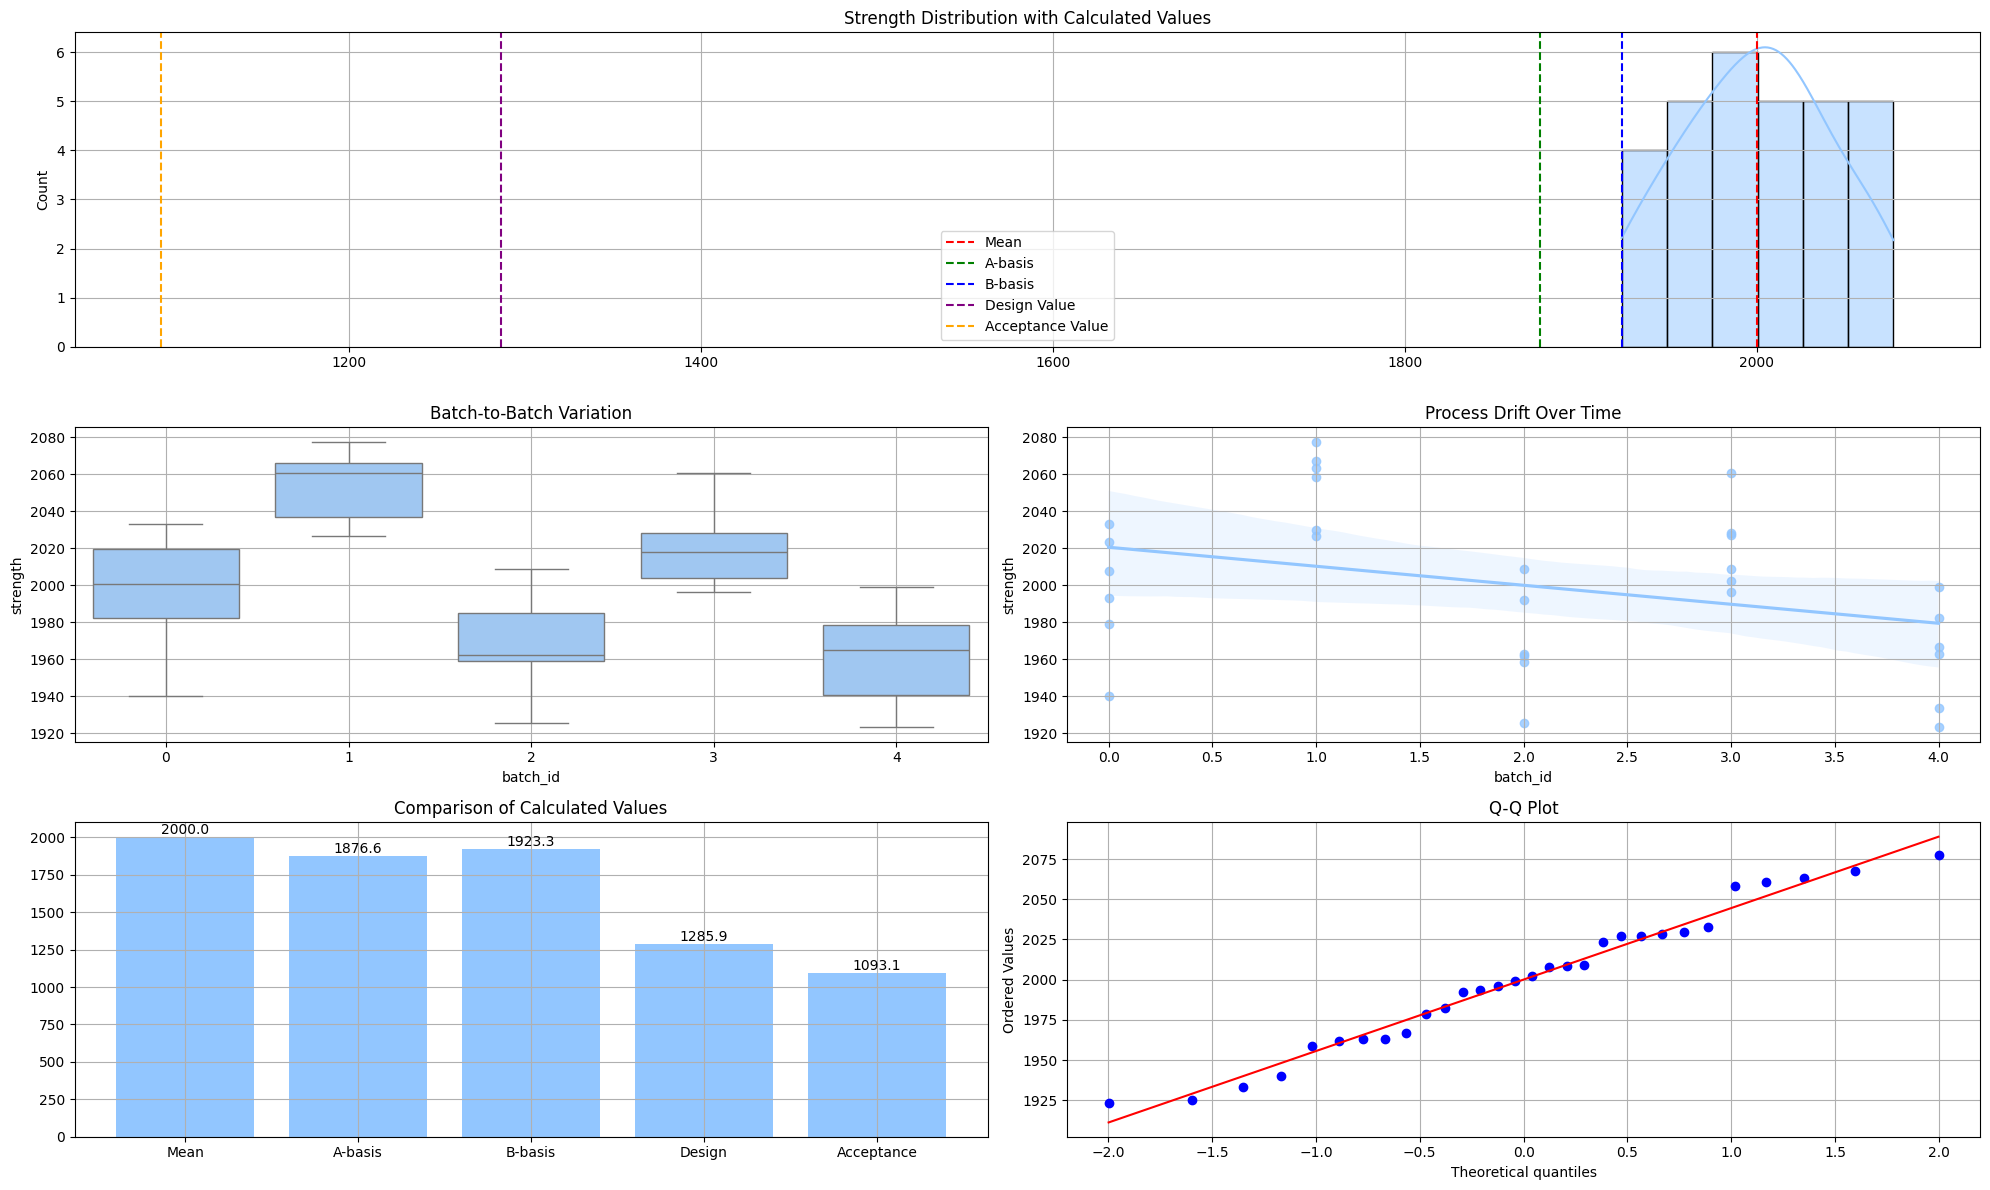

In [13]:
np.random.seed(42) 
analysis = CompositeAnalysis(
    mean_strength=1000,
    std_dev=50,
    num_batches=5,
    samples_per_batch=6
)

# Generate and analyze data
data, batch_info = analysis.generate_realistic_data()

# Create visualization and get values
fig, values = analysis.plot_comprehensive_analysis(data, batch_info)

# Validate and print results
analysis.print_analysis_summary(values)

# Show typical ranges
print("\nTypical Value Ranges (percentage of mean):")
print(f"A-basis: {values['a_basis']/values['mean']*100:.1f}%")
print(f"B-basis: {values['b_basis']/values['mean']*100:.1f}%")
print(f"Design: {values['design_value']/values['mean']*100:.1f}%")
print(f"Acceptance: {values['acceptance_value']/values['mean']*100:.1f}%")